In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import torch
import gym

import matplotlib.pyplot as plt

torch.manual_seed(42)

We can consider using a *baseline* $b$ in our result, which was originally introduced by [Williams, 1992](https://link.springer.com/article/10.1007/BF00992696). The paper in which the REINFORCE algorithm is introduced. 
$$
\nabla_{\boldsymbol{\theta}} J(\boldsymbol{\theta})=\frac{1}{m} \sum_{i=1}^{m} \sum_{t=1}^{H} \nabla_{\boldsymbol{\theta}} \log \pi_{\boldsymbol{\theta}}\left(\mathbf{a}_{t}^{(i)} \mid \mathbf{s}_{t}^{(i)}\right)\left[\sum_{k=t}^{H} \gamma^{k} r\left(\mathbf{s}_{k}^{(i)}, \mathbf{a}_{k}^{(i)}\right)-b\right]
$$

In [2]:
env = gym.make("CartPole-v1")

env.observation_space, env.action_space, env._max_episode_steps

(Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32),
 Discrete(2),
 500)

In [24]:
import torch.nn as nn
import torch.optim as optim
from gym.spaces import Discrete, Box
from torch.distributions.categorical import Categorical


class Model(nn.Module):
    def __init__(self, obs_dim, act_dim):
        super(Model, self).__init__()
        self.linear1 = nn.Linear(obs_dim, 128)
        self.linear2 = nn.Linear(128, act_dim)
        self.activation = nn.Tanh()
        
    def forward(self, x):
        x = self.activation(self.linear1(x))
        x = self.linear2(x)
        return x
    
class Agent:
    def __init__(self, env, baseline= None, 
                 gamma=0.99, lr=3e-2, hidden_size=64):
        assert baseline is not None, \
            "Give a baseline to compute the policy gradient"
        
        assert isinstance(env.observation_space, Box), \
            "This example only works for envs with continuous state spaces."
        assert isinstance(env.action_space, Discrete), \
            "This example only works for envs with discrete action spaces."
        
        self.env = env
        self.obs_dim = env.observation_space.shape[0]
        self.act_dim = env.action_space.n
        self.max_ep_len = env._max_episode_steps
        
        self.gamma = gamma
        self.baseline = baseline
        
        self.log_pi = Model(self.obs_dim, self.act_dim)
        self.opt = optim.Adam(self.log_pi.parameters(), lr=lr)
    
    def update_policy(self, act, obs, baseline):
        self.opt.zero_grad()
        
        # Calculate the loss
        logp = self.get_policy(obs).log_prob(act)
        batch_loss = -(logp * baseline).mean()  
        
        batch_loss.backward()
        self.opt.step()
        return batch_loss
        
    def get_policy(self, obs):
        logits = self.log_pi(obs)
        return Categorical(logits=logits)
    
    def get_action(self, obs, deterministic = False):
        # TODO: Setup deterministic get_action
        return self.get_policy(obs).sample().item()
    
    def sample_batch(self, batch_size=5000):
        batch_obs = []          # for observations
        batch_acts = []         # for actions
        batch_weights = []      # for R(tau) weighting in policy gradient
        batch_rets = []         # for measuring episode returns
        batch_lens = []         # for measuring episode lengths
        ep_rews = []            # list for rewards accrued throughout ep
        
        done = False
        o, ep_ret, ep_len = env.reset(), 0, 0
        while True:
            batch_obs.append(o)
            
            a = self.get_action(torch.as_tensor(o, dtype=torch.float32))
            o, r, done, _ = env.step(a)
            
            # save action, reward
            batch_acts.append(a)
            ep_rews.append(r)
            
            if done or(ep_len == self.max_ep_len):
                # if episode is over, record info about episode
                ep_ret, ep_len = sum(ep_rews), len(ep_rews)
                batch_rets.append(ep_ret)
                batch_lens.append(ep_len)
 
                # the weight for each logprob(a|s) is R(tau)
                # first naive implementation given,
                # batch_weights += [ep_ret] * ep_len
                
                # Discounted reward
                batch_weights += list(self.baseline(ep_rews, 
                                                    batch_obs, 
                                                    batch_acts, 
                                                    self.gamma))
                
                # reset episode-specific variables
                o, done, ep_rews = env.reset(), False, []
                
                if len(batch_obs) > batch_size:
                    break
        
        batch_loss = self.update_policy(
            torch.as_tensor(batch_acts, dtype=torch.float32),
            torch.as_tensor(batch_obs, dtype=torch.float32),
            torch.as_tensor(batch_weights, dtype=torch.float32))
        return batch_loss, batch_rets, batch_lens
    
    def train(self, epochs=50, batch_size=5000, print_out=False):
        ep_loss, ep_rets, ep_len = [], [], []
        
        for i in range(epochs):
            batch_loss, batch_rets, batch_lens = self.sample_batch(
                batch_size=batch_size)
        
            ep_loss.append(batch_loss)
            ep_rets.append(np.mean(batch_rets))
            ep_len.append(np.mean(batch_lens))
            
            print('epoch: %3d \t loss: %.3f \t return: %.3f \t ep_len: %.3f' %
                  (i, batch_loss, np.mean(batch_rets), np.mean(batch_lens)))
        
        return ep_loss, ep_rets, ep_len

Finally there are several possibilities for picking a baseline, namely,
$\nabla_{\boldsymbol{\theta}} J(\boldsymbol{\theta})=\mathbb{E}_{\mathbf{s}_{t}, \mathbf{a}_{t} \pi_{\boldsymbol{\theta}}(.)}\left[\nabla_{\boldsymbol{\theta}} \log \pi_{\boldsymbol{\theta}}\left(\mathbf{a}_{t}^{(i)} \mid \mathbf{s}_{t}^{(i)}\right)\right] \psi_{t} \text { where } \psi_{t} \text { can be: }$

* $\sum_{t=0}^{H} \gamma^{t} r_{t}:$ total (discounted) reward of trajectory
* $\sum_{k=t}^{H} \gamma^{k-t} r_{k}:$ sum of rewards after $\mathbf{a}_{t}$
* $\sum_{k=t}^{H} \gamma^{k-t} r_{k}-b\left(\mathbf{s}_{t}\right):$ sum of rewards after $\mathbf{a}_{t}$ with baseline
* $\delta_{t}=r_{t}+\gamma V^{\pi}\left(\mathbf{s}_{t+1}\right)-V^{\pi}\left(\mathbf{s}_{t}\right):$ error, with $V^{\pi}\left(\mathbf{s}_{t}\right)=\mathbb{E}_{\mathbf{a}_{t}}\left[\sum_{k=0}^{H} \gamma^{k} r_{t+l}\right]$
* $\hat{Q}_{\phi}^{\pi_{\theta}}\left(\mathbf{s}_{t}, \mathbf{a}_{t}\right)=\mathbb{E}_{a_{t+1}}\left[\sum_{k=0}^{H} \gamma^{k} r_{t+l}\right]:$ action-value function
* $\hat{A}_{\phi}^{\pi_{\theta}}\left(\mathbf{s}_{t}, \mathbf{a}_{t}\right)=\hat{Q}_{\phi}^{\pi_{\theta}}\left(\mathbf{s}_{t}, \mathbf{a}_{t}\right)-\hat{V}_{\phi}^{\pi_{\theta}}\left(\mathbf{s}_{t}\right)=\mathbb{E}\left[\delta_{t}\right]$, advantage function

In [25]:
# The baseline interface
# def baseline(rews, obs, acts, gamma = 0.99):
#   Return torch.Tensor

In [26]:
def reward_to_go(rews, obs = None, acts = None, gamma = None):
    n = len(rews)
    rtgs = np.zeros_like(rews)
    
    if gamma is not None:
        for i in reversed(range(n)):
            rtgs[i] = gamma**i * rews[i] + (rtgs[i+1] if i+1 < n else 0)
    else: 
        for i in reversed(range(n)):
            rtgs[i] = rews[i] + (rtgs[i+1] if i+1 < n else 0)
    return rtgs

(reward_to_go([10, 1, 2, 1, 3, 10], gamma = None),
    reward_to_go([10, 1, 2, 1, 3, 10], gamma = 0.99))

(array([27, 17, 16, 14, 13, 10]), array([22, 12, 12, 11, 11,  9]))

In [27]:
# TODO: Trick introduced in DeepRL bootcamp, 
# http://rail.eecs.berkeley.edu/deeprlcourse-fa17/f17docs/lecture_4_policy_gradient.pdf
# Should it be discounted here?
def reward_to_go_average(rews, obs = None, acts = None, gamma = None):
    n = len(rews)
    rtgs = np.zeros_like(rews)
    
    if gamma is not None:
        for i in reversed(range(n)):
            rtgs[i] = gamma**i * rews[i] + (rtgs[i+1] if i+1 < n else 0)
    else: 
        for i in reversed(range(n)):
            rtgs[i] = rews[i] + (rtgs[i+1] if i+1 < n else 0)
            
    # baseline r_bar
    return rtgs - np.mean(rews)

(reward_to_go_average([10, 1, 2, 1, 3, 10], gamma = None),
    reward_to_go_average([10, 1, 2, 1, 3, 10], gamma = 0.99))

(array([22.5, 12.5, 11.5,  9.5,  8.5,  5.5]),
 array([17.5,  7.5,  7.5,  6.5,  6.5,  4.5]))

In [28]:
# TODO: Using value function as baseline

In [54]:
# TODO: Add some plots, for different baselines to compare
runs = 2
agent = Agent(env, baseline=reward_to_go) # gamma = None, to train undiscounted

loss = []
rets = []
length = []

for i in range(runs):
    # gamma = None, to train undiscounted
    agent = Agent(env, baseline=reward_to_go) 
    ep_loss, ep_rets, ep_len = agent.train(epochs=10)
    loss.append(ep_loss)
    rets.append(ep_rets)
    length.append(ep_len)

epoch:   0 	 loss: 7.460 	 return: 20.181 	 ep_len: 20.181
epoch:   1 	 loss: 11.286 	 return: 42.218 	 ep_len: 42.218
epoch:   2 	 loss: 9.370 	 return: 39.803 	 ep_len: 39.803
epoch:   3 	 loss: 10.717 	 return: 56.133 	 ep_len: 56.133
epoch:   4 	 loss: 11.129 	 return: 71.028 	 ep_len: 71.028
epoch:   5 	 loss: 9.590 	 return: 59.786 	 ep_len: 59.786
epoch:   6 	 loss: 9.622 	 return: 66.693 	 ep_len: 66.693
epoch:   7 	 loss: 8.599 	 return: 66.840 	 ep_len: 66.840
epoch:   8 	 loss: 8.445 	 return: 76.279 	 ep_len: 76.279
epoch:   9 	 loss: 8.067 	 return: 77.030 	 ep_len: 77.030
epoch:   0 	 loss: 6.616 	 return: 17.503 	 ep_len: 17.503
epoch:   1 	 loss: 6.775 	 return: 21.177 	 ep_len: 21.177
epoch:   2 	 loss: 11.721 	 return: 51.081 	 ep_len: 51.081
epoch:   3 	 loss: 11.480 	 return: 55.811 	 ep_len: 55.811
epoch:   4 	 loss: 11.557 	 return: 65.429 	 ep_len: 65.429
epoch:   5 	 loss: 11.384 	 return: 70.479 	 ep_len: 70.479
epoch:   6 	 loss: 10.922 	 return: 76.106 	 ep_l

/home/rob/.conda/envs/meta/lib/python3.7/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


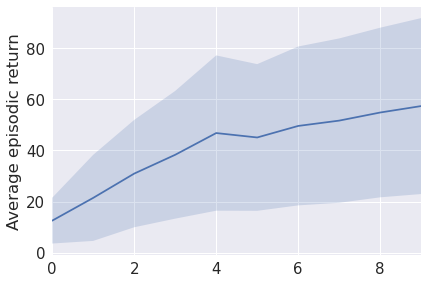

In [77]:
# Plot outputs of the multiple runs
sns.tsplot(data=rets, ci='sd', time=np.arange(10), value="Average episodic return")
plt.tight_layout(pad=0.5)